In [13]:
import os

import numpy as np
import pandas as pd
import scipy.stats as sts
import matplotlib
import matplotlib.pyplot as plt
import seaborn as sns

sns.set_style('white')
sns.set_context('talk')

matplotlib.rcParams['xtick.labelsize'] = 10
matplotlib.rcParams['ytick.labelsize'] = 10
matplotlib.rcParams['axes.labelsize'] = 12
matplotlib.rcParams['legend.fontsize'] = 12
matplotlib.rcParams['mathtext.fontset'] = 'custom'
matplotlib.rcParams['mathtext.rm'] = 'Bitstream Vera Sans'
matplotlib.rcParams['mathtext.default'] = 'rm'
matplotlib.rcParams['mathtext.it'] = 'Bitstream Vera Sans:italic'
matplotlib.rcParams['mathtext.bf'] = 'Bitstream Vera Sans:bold'

%matplotlib inline

In [5]:
files = [f for f in os.listdir('./results') if f[-3:]=='csv']
d0 = pd.read_csv('./results/' + files[0])

D = d0.loc[:, ['subject', 'color', 'bp', 'wp', 'response', 'rt', 'splitg', 'n_pieces']]

D = D.copy()

names = [f[14:-4] for f in files if f[:3]=='app']

for f in files:
    if f[:3]=='app':
        _d = pd.read_csv('./results/' + f)
        D.loc[:, f[14:-4]] = _d.cnn_nll.values
    
D.head()

,subject,color,bp,wp,response,rt,splitg,n_pieces,naive_1,naive_128,...,naive_8,smart_1,smart_128,smart_16,smart_2,smart_256,smart_32,smart_4,smart_64,smart_8
0,0,0,000000000000000000000000000000000000,000000000000000000000000000000000000,11,7223,5,0,3.516745,4.128196,...,3.884012,3.546878,4.156188,4.037173,3.698342,4.186132,4.094836,4.019267,4.143282,3.887828
1,1,1,000000000000000000000000000000000000,000000000001000000000000000000000000,24,5141,5,1,3.588722,4.244206,...,4.161124,3.568749,4.443789,4.488919,3.894595,4.552783,4.360919,4.377874,4.266925,4.397906
2,0,0,000000000001000000000000000000000000,000000000000000000000000100000000000,21,3154,5,2,2.761279,2.656283,...,2.714588,2.712107,2.702742,2.805940,2.631602,2.804832,2.510506,2.553612,2.656333,2.450614
3,1,1,000000000000000000000000100000000000,000000000001000000000100000000000000,31,5715,4,3,2.744632,0.757582,...,2.663838,2.962218,0.889912,1.549567,2.885014,0.762685,1.037952,2.643039,0.903978,2.191686
4,0,0,000000000001000000000100000000000000,000000000000000000000000100000010000,14,6837,3,4,2.631289,3.979000,...,3.255823,2.811628,4.013144,3.200343,2.605702,4.114066,3.300314,3.008024,3.583677,3.317387


In [6]:
L = pd.read_csv('./results/loglik_by_board_default.txt', names=['n_pieces', 'default'])
D.loc[:, 'default'] = L.default.values

In [86]:
levels = 2**np.arange(9)
types = ['smart', 'naive']
m_smart, m_naive, l_smart, l_naive, u_smart, u_naive = [np.zeros(9) for _ in range(6)]

for name in names:
    n = np.log2(int(name[6:]))
    if name[:5]=='naive':
        m, l, u = m_naive, l_naive, u_naive
    else:
        m, l, u = m_smart, l_smart, u_smart
    
    mstats, _, _ = sts.bayes_mvs(D.loc[:, name].values)
    m[n] = mstats[0]
    l[n] = mstats[1][0]
    u[n] = mstats[1][1]
    
mstats_default, _, _ = sts.bayes_mvs(D.loc[:, 'default'].values, alpha=.95)
m_default, l_default, u_default = mstats_default[0], mstats_default[1][0], mstats_default[1][1]

/Users/gianni/anaconda3/lib/python3.5/site-packages/ipykernel/__main__.py:13: VisibleDeprecationWarning: using a non-integer number instead of an integer will result in an error in the future
/Users/gianni/anaconda3/lib/python3.5/site-packages/ipykernel/__main__.py:14: VisibleDeprecationWarning: using a non-integer number instead of an integer will result in an error in the future
/Users/gianni/anaconda3/lib/python3.5/site-packages/ipykernel/__main__.py:15: VisibleDeprecationWarning: using a non-integer number instead of an integer will result in an error in the future


In [87]:
print(
    'Is 32 filters significantly better than 16?\n', 
    sts.ttest_ind(D.smart_16.values, D.smart_32.values)
)

print(
    'Is 64 better than 32?\n',
    sts.ttest_ind(D.smart_32.values, D.smart_64.values)
)

print(
    'Just to check, is smart 32 better than naive 32?\n',
    sts.ttest_ind(D.smart_32.values, D.naive_32.values)
)

print(
    'It is official: best CNN is 32 filter with rule knowledge'
)

Is 32 filters significantly better than 16?
 Ttest_indResult(statistic=2.824811767905997, pvalue=0.0047393843761417325)
Is 64 better than 32?
 Ttest_indResult(statistic=0.2794634170172306, pvalue=0.77989448143014772)
Just to check, is smart 32 better than naive 32?
 Ttest_indResult(statistic=-4.8114314251573074, pvalue=1.5185083975927674e-06)
It is official: best CNN is 32 filter with rule knowledge


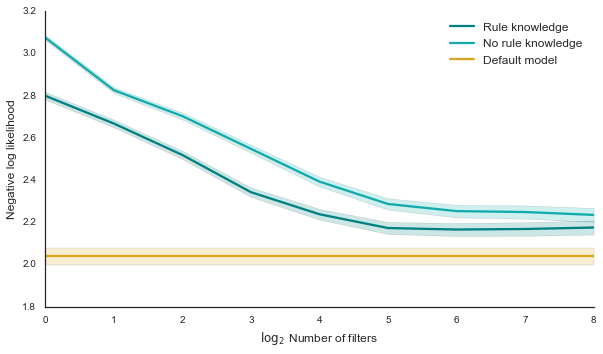

In [88]:
fig, axes = plt.subplots(1, 1, figsize=(8.5, 5), squeeze=False)

trends = axes[0, 0]

trends.plot(np.arange(9), m_smart, label='Rule knowledge', color='teal')
trends.fill_between(
    np.arange(9), l_smart, u_smart, 
    zorder=0, alpha=.2, facecolor='teal'
)

trends.plot(np.arange(9), m_naive, label='No rule knowledge', color='#11AAAA')
trends.fill_between(
    np.arange(9), l_naive, u_naive, 
    zorder=1, alpha=.2, facecolor='#11AAAA'
)

trends.plot([0, 8], [m_default, m_default], label='Default model', color='goldenrod')
trends.fill_between(
    [0, 8], [l_default,]*2, [u_default,]*2, 
    alpha=.2, facecolor='goldenrod'
)

plt.setp(trends, xlabel=r'$\log_2{}$ Number of filters', ylabel='Negative log likelihood')

trends.legend()
sns.despine()
fig.tight_layout()
fig.savefig('./results/trends.png')

In [15]:
B = pd.read_csv('./results/appended_data_smart_32.csv')
B.columns

Index(['subject', 'color', 'bp', 'wp', 'response', 'rt', 'splitg', 'cnn_nll',
       'n_pieces', 'cnn_0', 'cnn_1', 'cnn_2', 'cnn_3', 'cnn_4', 'cnn_5',
       'cnn_6', 'cnn_7', 'cnn_8', 'cnn_9', 'cnn_10', 'cnn_11', 'cnn_12',
       'cnn_13', 'cnn_14', 'cnn_15', 'cnn_16', 'cnn_17', 'cnn_18', 'cnn_19',
       'cnn_20', 'cnn_21', 'cnn_22', 'cnn_23', 'cnn_24', 'cnn_25', 'cnn_26',
       'cnn_27', 'cnn_28', 'cnn_29', 'cnn_30', 'cnn_31', 'cnn_32', 'cnn_33',
       'cnn_34', 'cnn_35', 'prediction'],
      dtype='object')

In [53]:
reconstitute = lambda x: np.array(list(map(int, x))).reshape(4,9)

def show_output(pos, ax, df, show_zet=False):
    positions = ['cnn_' + str(i) for i in range(36)]
    d = df.loc[pos, positions].values.reshape([4,9]).astype(float)

    sns.heatmap(
        d, ax=ax, 
        square=True, vmin=0, vmax=.25, cbar=False, linewidth=1, linecolor='black',
        cmap=sns.palettes.blend_palette(['#999999', '#66FF66'], n_colors=18, as_cmap=True),
        xticklabels=False, yticklabels=False, annot=True, fmt='.2f'
    )

    if df.loc[pos, 'color'] == 0:
        own_color, opp_color = 'black', 'white'
    else:
        own_color, opp_color = 'white', 'black'

    p = np.where(reconstitute(df.loc[pos, 'bp'])==1)
    ax.scatter( .5 + p[1], 3.5 - p[0], c=own_color, s=400)
    
    p = np.where(reconstitute(df.loc[pos, 'wp'])==1)
    ax.scatter( .5 + p[1], 3.5 - p[0], c=opp_color, s=400)
    
    if show_zet:
        r = B.loc[pos, 'response']
        p = (r % 9, r // 9)
        ax.plot(
            p[0] + .5, 3.5 - p[1], 
            linestyle='None', 
            marker='o', markersize=20, markerfacecolor='None', 
            markeredgecolor='black', markeredgewidth=1
        );
        

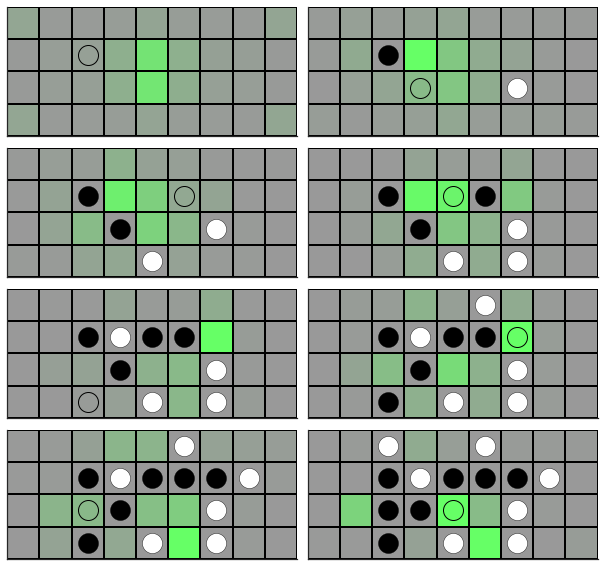

In [80]:
fig = plt.figure(figsize=(8.5, 8))
gs = matplotlib.gridspec.GridSpec(4, 2)

for i in np.arange(8):
    ax = plt.subplot(gs[i//2, i%2])
    show_output(pos=i*2, ax=ax, df=B, show_zet=True)
    
sns.despine()

plt.tight_layout()
fig.savefig('examples.png', bbox_inches='tight')

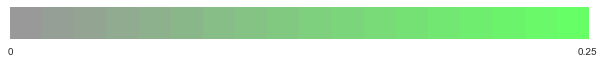

In [82]:
fig, cplot = plt.subplots(1, 1, figsize=(8.5, 1))

cplot.imshow(
    np.linspace(0, .25, 18).reshape(1, 18),
    cmap=sns.palettes.blend_palette(['#999999', '#66FF66'], n_colors=18, as_cmap=True),
    interpolation="nearest"#, aspect="auto"
)

plt.setp(
    cplot, xticklabels=[0, .25], xticks=[-.5, 17.5]
)
cplot.yaxis.set_visible(False)
cplot.bbox.size[0] = 500
sns.despine(ax=cplot, bottom=True, left=True)
fig.tight_layout()
fig.savefig('colorbar.png')

In [84]:
pd.read_csv('./results/trace_0.csv')

,8.409187441302167088e+01,6.346977390864072532e+00,2.520000000000000018e-01,8.333373980905119538e+01,6.338279765078507211e+00,2.419999999999999929e-01,8.381459181986772933e+01,6.328268052609852035e+00,2.640000000000000124e-01,8.378895073971111174e+01,6.355881146330030873e+00,2.399999999999999911e-01,8.302722081409615384e+01,6.357721743322249708e+00,2.200000000000000011e-01
0,82.158707,6.287640,0.280,82.238853,6.284871,0.250,82.163314,6.264910,0.298,82.010992,6.294723,0.260,82.044505,6.299650,0.248
1,81.431360,6.231483,0.278,81.548749,6.235732,0.266,81.500407,6.207098,0.294,81.254380,6.238644,0.262,81.289099,6.247807,0.258
2,80.781186,6.180964,0.272,80.920910,6.192137,0.266,80.891878,6.154726,0.300,80.604663,6.188182,0.266,80.615551,6.202396,0.252
3,80.181340,6.136389,0.276,80.376213,6.152715,0.262,80.359893,6.107802,0.294,80.025563,6.144010,0.270,80.006547,6.161917,0.250
4,79.657454,6.097225,0.278,79.880176,6.118372,0.264,79.885575,6.066550,0.296,79.522586,6.104180,0.286,79.479881,6.126715,0.256
5,79.193938,6.061281,0.272,79.436723,6.088055,0.264,79.468996,6.028756,0.288,79.031952,6.069149,0.292,79.016313,6.095333,0.258
6,78.777610,6.030306,0.266,79.021934,6.061710,0.266,79.137508,5.995238,0.280,78.651029,6.037859,0.292,78.607887,6.067939,0.258
7,78.456885,6.002460,0.270,78.721687,6.038637,0.268,78.791637,5.965179,0.288,78.298400,6.010078,0.292,78.273382,6.043943,0.254
8,78.145225,5.977753,0.272,78.416386,6.018099,0.266,78.514370,5.938211,0.286,77.977080,5.985454,0.292,77.905082,6.022923,0.256
9,77.829919,5.955877,0.272,78.123294,5.999945,0.264,78.258463,5.914244,0.288,77.724987,5.963588,0.288,77.637892,6.004311,0.256
